In [3]:
pip install numpy==1.26



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/home/augustynka/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



>> im0163  —  balanced_score = 0.736


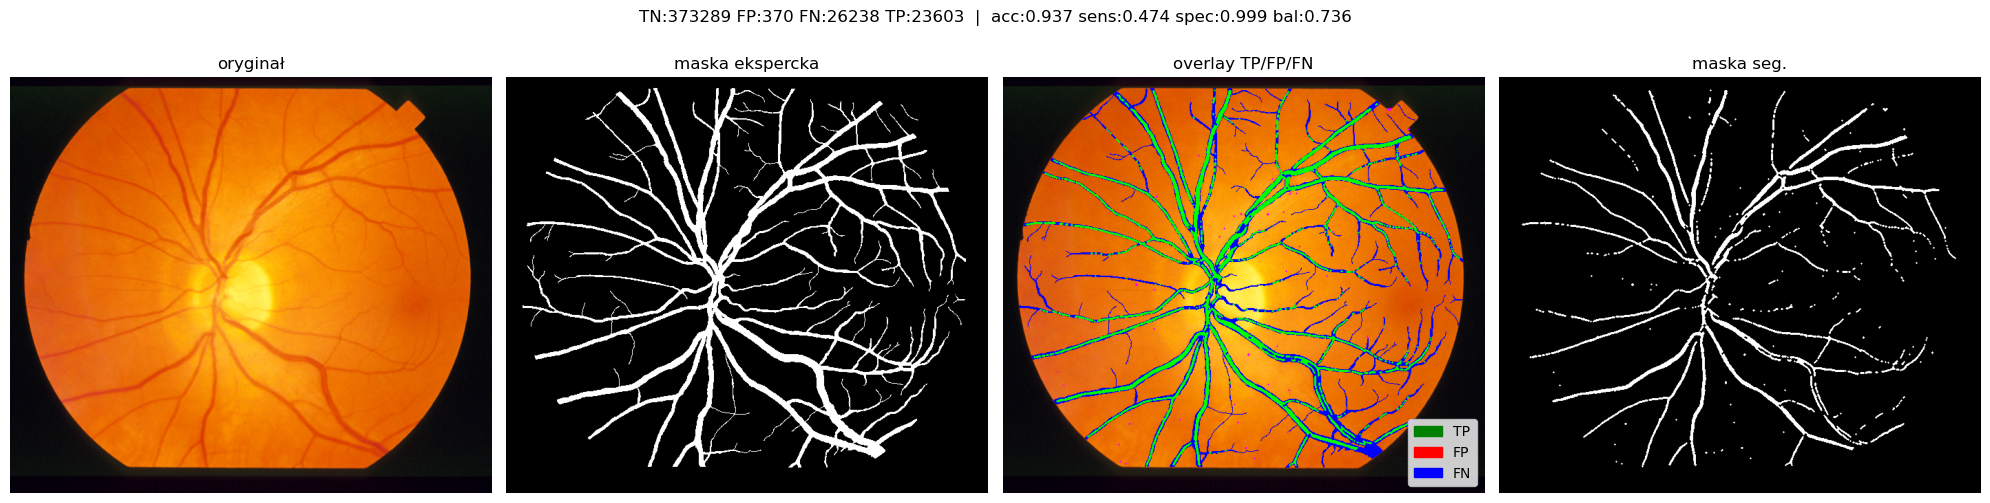


>> im0255  —  balanced_score = 0.700


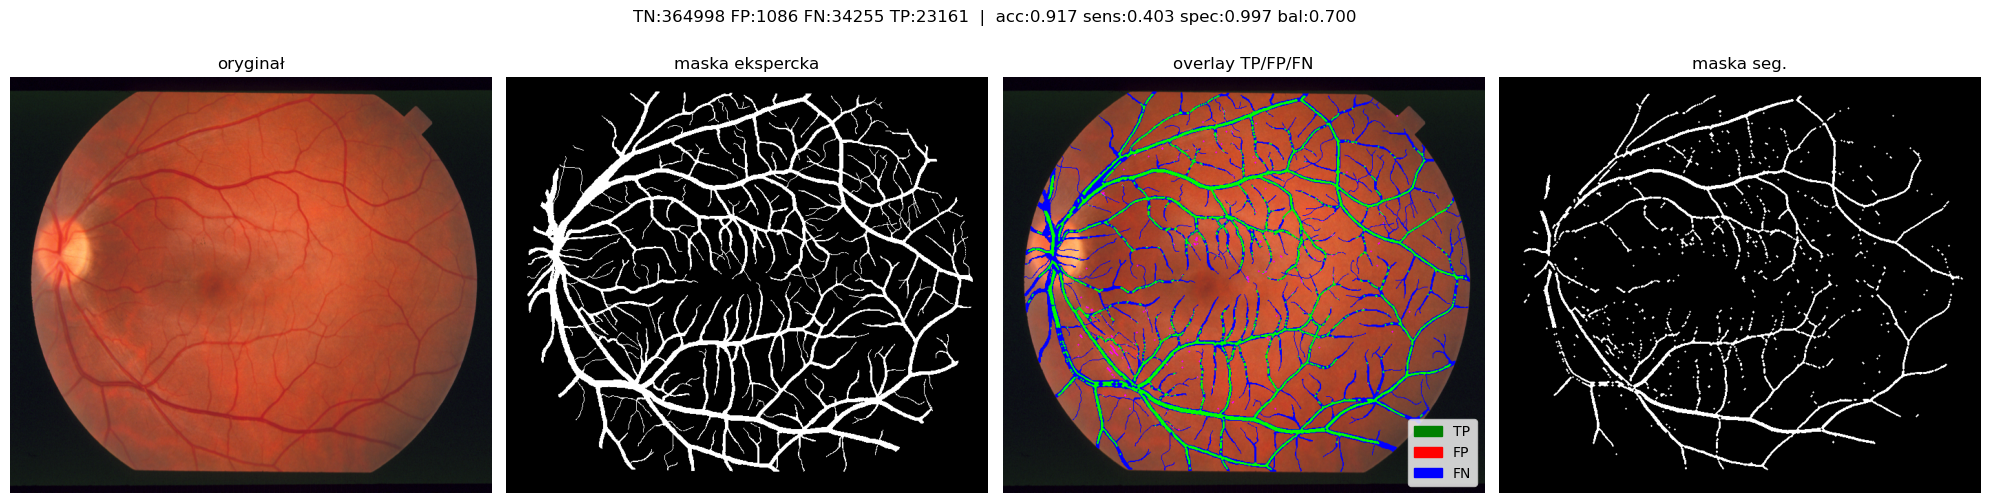


>> im0236  —  balanced_score = 0.695


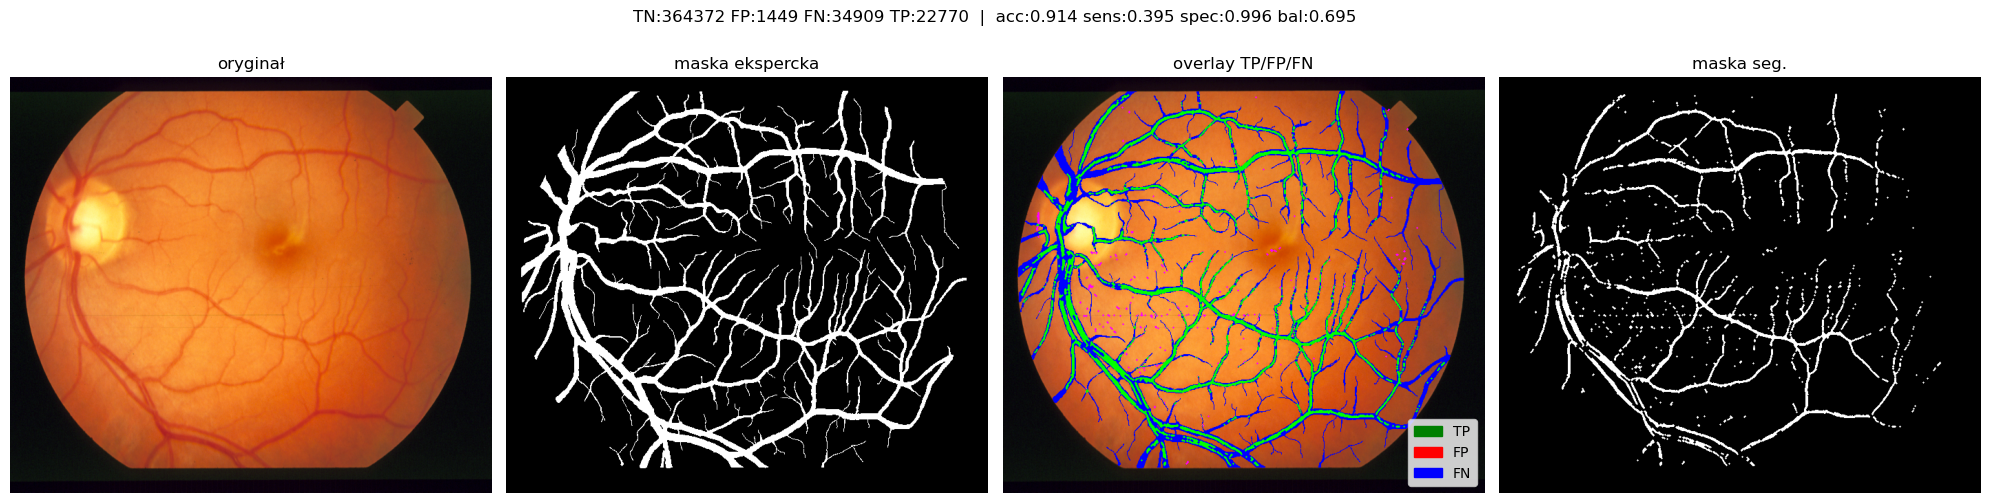


>> im0004  —  balanced_score = 0.520


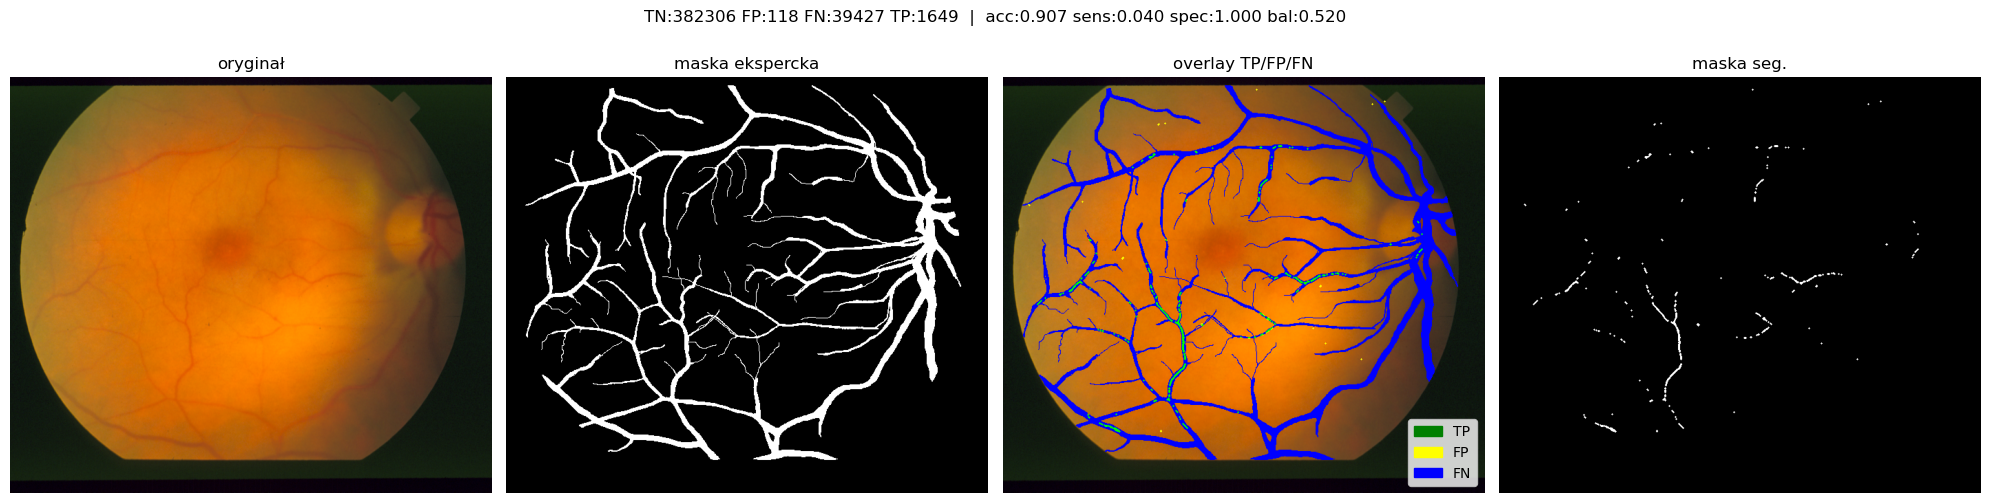


>> im0324  —  balanced_score = 0.519


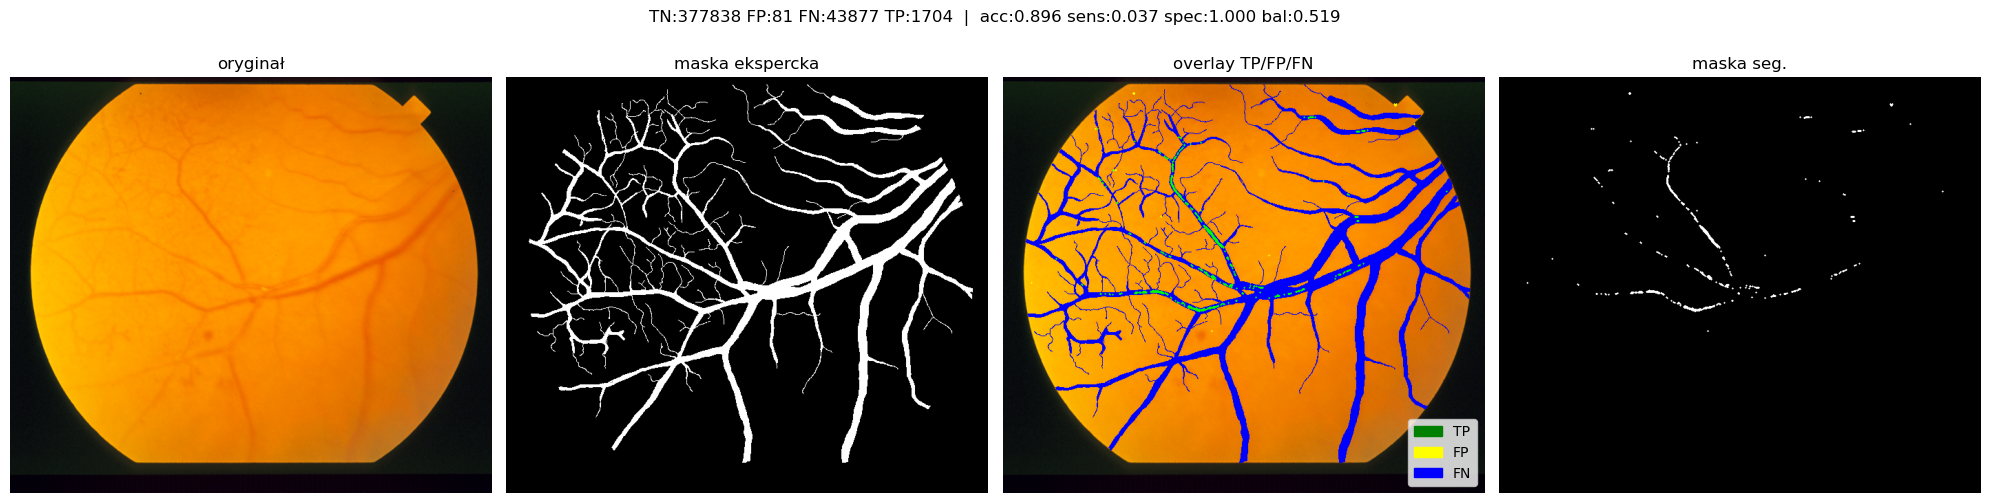


===== ZBIORCZE METRYKI DLA WSZYSTKICH OBRAZÓW =====
      accuracy  sensitivity  specificity  balanced_score
mean  0.910214     0.233222     0.997268        0.615245
std   0.018406     0.124003     0.004610        0.061634
min   0.872357     0.037384     0.978887        0.518585
max   0.941216     0.473566     0.999884        0.736288

Łączna macierz pomyłek: [[TN:7464124, FP:20508] [FN:739983, TP:245385]]
Zbiorcze metryki:
  Accuracy:    0.9102
  Sensitivity: 0.2490
  Specificity: 0.9973
  Balanced:    0.6231


In [1]:
import os
import gzip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import pandas as pd
import matplotlib.patches as mpatches

# --- ŚCIEŻKI ---
base_dir      = "."
images_dir    = os.path.join(base_dir, "star_images")
ah_masks_dir  = os.path.join(base_dir, "labels_ah")
vk_masks_dir  = os.path.join(base_dir, "lables_vk")

# --- FUNKCJE POMOCNICZE ---
def load_ppm_gz(path_to_gz):
    with gzip.open(path_to_gz, 'rb') as f:
        buf = f.read()
    arr = np.frombuffer(buf, dtype=np.uint8)
    return cv2.imdecode(arr, cv2.IMREAD_UNCHANGED)

def apply_preprocessing(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(gray)

def create_field_of_view_mask(gray):
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    close = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kern)
    open_ = cv2.morphologyEx(close, cv2.MORPH_OPEN, kern)
    return (open_ > 0).astype(np.uint8)

def postprocess_mask(bin_mask):
    kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    close = cv2.morphologyEx(bin_mask, cv2.MORPH_CLOSE, kern)
    open_ = cv2.morphologyEx(close, cv2.MORPH_OPEN, kern)
    return open_

def get_metrics(gt, pred):
    y_true = gt.flatten()
    y_pred = pred.flatten()
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc  = accuracy_score(y_true, y_pred)
    sens = recall_score(y_true, y_pred)
    spec = tn / (tn + fp) if (tn+fp)>0 else 0
    return acc, sens, spec, (sens+spec)/2, (tn, fp, fn, tp)

# --- GŁÓWNY BLOK: liczymy metryki dla wszystkich obrazów ---
image_files = sorted(f for f in os.listdir(images_dir) if f.endswith(".ppm.gz"))
all_results = []
total_cm = np.array([0,0,0,0], dtype=int)

for file in image_files:
    name = file.replace(".ppm.gz","")
    # wczytanie obrazów i masek
    img      = load_ppm_gz(os.path.join(images_dir, file))
    mask_ah  = load_ppm_gz(os.path.join(ah_masks_dir,  f"{name}.ah.ppm.gz"))
    vk_path  = os.path.join(vk_masks_dir,      f"{name}.vk.ppm.gz")
    has_vk   = os.path.exists(vk_path)
    mask_ah_bin = (mask_ah>0).astype(np.uint8)
    if has_vk:
        mask_vk     = load_ppm_gz(vk_path)
        mask_vk_bin = (mask_vk>0).astype(np.uint8)
        gt_mask     = ((mask_ah_bin+mask_vk_bin)>=1).astype(np.uint8)
    else:
        gt_mask     = mask_ah_bin

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray    = apply_preprocessing(img_rgb)
    fov     = create_field_of_view_mask(gray)
    vessel_prob       = frangi(gray.astype(np.float64)/255.0)
    vessel_bin_raw    = (vessel_prob>0.03).astype(np.uint8)
    vessel_bin_masked = postprocess_mask(vessel_bin_raw * fov)

    acc, sens, spec, bal, cm = get_metrics(gt_mask, vessel_bin_masked)
    total_cm += np.array(cm)

    all_results.append({
        "file": file,
        "name": name,
        "accuracy": acc,
        "sensitivity": sens,
        "specificity": spec,
        "balanced_score": bal
    })

# --- WYBIERAMY 3 najlepsze ---
top3 = sorted(all_results, key=lambda x: x["balanced_score"], reverse=True)[:3]
bad2 = sorted(all_results, key=lambda x: x["balanced_score"], reverse=True)[-2:]

# --- WIZUALIZACJE I MACIERZE POMYŁEK dla top3 ---
for res in top3:
    file = res["file"]
    name = res["name"]
    print(f"\n>> {name}  —  balanced_score = {res['balanced_score']:.3f}")

    # ponowne wczytanie i przetwarzanie (żeby mieć maski i overlay)
    img      = load_ppm_gz(os.path.join(images_dir, file))
    mask_ah  = load_ppm_gz(os.path.join(ah_masks_dir,  f"{name}.ah.ppm.gz"))
    vk_path  = os.path.join(vk_masks_dir,      f"{name}.vk.ppm.gz")
    mask_ah_bin = (mask_ah>0).astype(np.uint8)
    if os.path.exists(vk_path):
        mask_vk     = load_ppm_gz(vk_path)
        mask_vk_bin = (mask_vk>0).astype(np.uint8)
        gt_mask     = ((mask_ah_bin+mask_vk_bin)>=1).astype(np.uint8)
    else:
        gt_mask     = mask_ah_bin

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray    = apply_preprocessing(img_rgb)
    fov     = create_field_of_view_mask(gray)
    vessel_prob       = frangi(gray.astype(np.float64)/255.0)
    vessel_bin_raw    = (vessel_prob>0.03).astype(np.uint8)
    vessel_bin_masked = postprocess_mask(vessel_bin_raw * fov)
    acc, sens, spec, bal, (tn,fp,fn,tp) = get_metrics(gt_mask, vessel_bin_masked)

    # przygotowanie masek TP/FP/FN/TN
    tn_mask = (gt_mask==0) & (vessel_bin_masked==0)
    fp_mask = (gt_mask==0) & (vessel_bin_masked==1)
    fn_mask = (gt_mask==1) & (vessel_bin_masked==0)
    tp_mask = (gt_mask==1) & (vessel_bin_masked==1)

    overlay = img_rgb.copy()
    overlay[fp_mask] = [255,0,255]   # FP czerwony
    overlay[fn_mask] = [0,0,255]   # FN niebieski
    overlay[tp_mask] = [0,255,0]   # TP zielony

    # legenda
    magenta_patch   = mpatches.Patch(color='red',   label='FP')
    blue_patch  = mpatches.Patch(color='blue',  label='FN')
    green_patch = mpatches.Patch(color='green', label='TP')

    fig, axs = plt.subplots(1,4,figsize=(20,5))
    axs[0].imshow(img_rgb);              axs[0].set_title('oryginał'); axs[0].axis('off')
    axs[1].imshow(gt_mask, cmap='gray'); axs[1].set_title('maska ekspercka'); axs[1].axis('off')
    axs[2].imshow(overlay);              axs[2].set_title('overlay TP/FP/FN'); axs[2].axis('off')
    axs[2].legend(handles=[green_patch, magenta_patch, blue_patch], loc='lower right')
    axs[3].imshow(vessel_bin_masked, cmap='gray'); axs[3].set_title('maska seg.'); axs[3].axis('off')
    plt.suptitle(f"TN:{tn} FP:{fp} FN:{fn} TP:{tp}  |  acc:{acc:.3f} sens:{sens:.3f} spec:{spec:.3f} bal:{bal:.3f}", fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

for res in bad2:
    file = res["file"]
    name = res["name"]
    print(f"\n>> {name}  —  balanced_score = {res['balanced_score']:.3f}")

    # ponowne wczytanie i przetwarzanie (żeby mieć maski i overlay)
    img      = load_ppm_gz(os.path.join(images_dir, file))
    mask_ah  = load_ppm_gz(os.path.join(ah_masks_dir,  f"{name}.ah.ppm.gz"))
    vk_path  = os.path.join(vk_masks_dir,      f"{name}.vk.ppm.gz")
    mask_ah_bin = (mask_ah>0).astype(np.uint8)
    if os.path.exists(vk_path):
        mask_vk     = load_ppm_gz(vk_path)
        mask_vk_bin = (mask_vk>0).astype(np.uint8)
        gt_mask     = ((mask_ah_bin+mask_vk_bin)>=1).astype(np.uint8)
    else:
        gt_mask     = mask_ah_bin

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray    = apply_preprocessing(img_rgb)
    fov     = create_field_of_view_mask(gray)
    vessel_prob       = frangi(gray.astype(np.float64)/255.0)
    vessel_bin_raw    = (vessel_prob>0.03).astype(np.uint8)
    vessel_bin_masked = postprocess_mask(vessel_bin_raw * fov)
    acc, sens, spec, bal, (tn,fp,fn,tp) = get_metrics(gt_mask, vessel_bin_masked)

    # przygotowanie masek TP/FP/FN/TN
    tn_mask = (gt_mask==0) & (vessel_bin_masked==0)
    fp_mask = (gt_mask==0) & (vessel_bin_masked==1)
    fn_mask = (gt_mask==1) & (vessel_bin_masked==0)
    tp_mask = (gt_mask==1) & (vessel_bin_masked==1)

    overlay = img_rgb.copy()
    overlay[fp_mask] = [255,255,0]   # FP zółty
    overlay[fn_mask] = [0,0,255]   # FN niebieski
    overlay[tp_mask] = [0,255,0]   # TP zielony

    # legenda
    yellow_patch   = mpatches.Patch(color='yellow',   label='FP')
    blue_patch  = mpatches.Patch(color='blue',  label='FN')
    green_patch = mpatches.Patch(color='green', label='TP')

    fig, axs = plt.subplots(1,4,figsize=(20,5))
    axs[0].imshow(img_rgb);              axs[0].set_title('oryginał'); axs[0].axis('off')
    axs[1].imshow(gt_mask, cmap='gray'); axs[1].set_title('maska ekspercka'); axs[1].axis('off')
    axs[2].imshow(overlay);              axs[2].set_title('overlay TP/FP/FN'); axs[2].axis('off')
    axs[2].legend(handles=[green_patch, yellow_patch, blue_patch], loc='lower right')
    axs[3].imshow(vessel_bin_masked, cmap='gray'); axs[3].set_title('maska seg.'); axs[3].axis('off')
    plt.suptitle(f"TN:{tn} FP:{fp} FN:{fn} TP:{tp}  |  acc:{acc:.3f} sens:{sens:.3f} spec:{spec:.3f} bal:{bal:.3f}", fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()


# --- PODSUMOWANIE dla WSZYSTKICH obrazów ---
df = pd.DataFrame(all_results)
print("\n===== ZBIORCZE METRYKI DLA WSZYSTKICH OBRAZÓW =====")
print(df.describe().loc[['mean','std','min','max'], ['accuracy','sensitivity','specificity','balanced_score']])

# łączna macierz pomyłek
tn, fp, fn, tp = total_cm
accuracy_total     = (tp+tn)/(tp+tn+fp+fn)
sensitivity_total  = tp/(tp+fn) if tp+fn>0 else 0
specificity_total  = tn/(tn+fp) if tn+fp>0 else 0
balanced_total     = (sensitivity_total+specificity_total)/2

print(f"\nŁączna macierz pomyłek: [[TN:{tn}, FP:{fp}] [FN:{fn}, TP:{tp}]]")
print(f"Zbiorcze metryki:\n  Accuracy:    {accuracy_total:.4f}\n  Sensitivity: {sensitivity_total:.4f}\n  Specificity: {specificity_total:.4f}\n  Balanced:    {balanced_total:.4f}")


Wybrany próg z ROC (Youden’s J): 1.000

==== im0005 ====
Accuracy:    0.9102
Sensitivity: 0.6134
Specificity: 0.9514
Confusion matrix:
[[TN:353726, FP:18051]
 [FN:19994, TP:31729]]


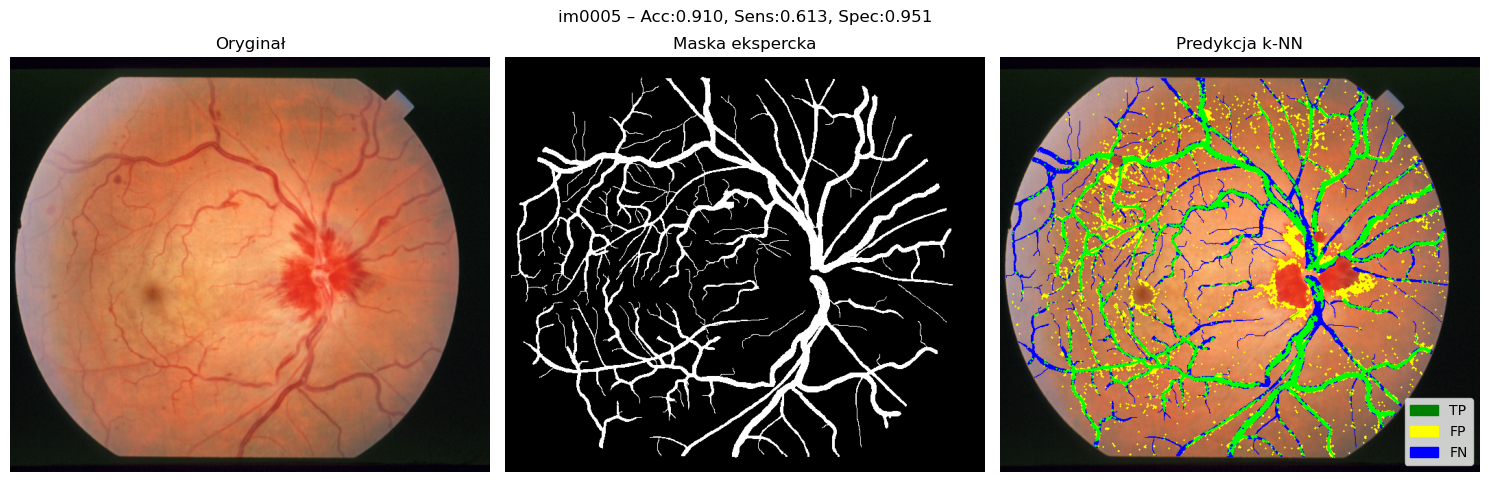

In [9]:
import os
import gzip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import moments_central, moments_hu
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score,
    roc_curve
)
from sklearn.model_selection import train_test_split


base_dir     = "."
images_dir   = os.path.join(base_dir, "star_images")
ah_masks_dir = os.path.join(base_dir, "labels_ah")
vk_masks_dir = os.path.join(base_dir, "lables_vk")

files    = sorted(f for f in os.listdir(images_dir) if f.endswith(".ppm.gz"))
train_f  = files[:4]     
test_f   = files[4:]     

def create_fov(gray):
    _, t = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    k    = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    m    = cv2.morphologyEx(t, cv2.MORPH_CLOSE, k)
    m    = cv2.morphologyEx(m, cv2.MORPH_OPEN,  k)
    return (m > 0).astype(np.uint8)

def get_metrics(gt, pred):
    y_t, y_p       = gt.flatten(), pred.flatten()
    tn, fp, fn, tp = confusion_matrix(y_t, y_p).ravel()
    acc   = accuracy_score(y_t, y_p)
    sens  = recall_score(y_t, y_p, zero_division=0)
    spec  = tn / (tn + fp) if (tn + fp) > 0 else 0
    return acc, sens, spec, (tn, fp, fn, tp)

def extract_features_from_patch(patch):
    p = patch.astype(np.float64)
    v = np.var(p)
    mean_intensity = np.mean(p)
    gx = cv2.Sobel(p, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(p, cv2.CV_64F, 0, 1, ksize=3)
    grad_mean = np.mean(np.sqrt(gx**2 + gy**2))
    if v == 0.0:
        hu = [0.0]*7
    else:
        mc = moments_central(p)
        hu = moments_hu(mc)
        hu = [0.0 if np.isnan(x) or np.isinf(x) else x for x in hu]
    return [v, mean_intensity, grad_mean] + hu

def extract_data(gray, mask, patch_size=5, stride=1):
    X, y, coords = [], [], []
    off = patch_size // 2
    h, w = gray.shape
    for i in range(off, h-off, stride):
        for j in range(off, w-off, stride):
            if mask[i, j] not in (0, 1):
                continue
            patch = gray[i-off:i+off+1, j-off:j+off+1]
            feats = extract_features_from_patch(patch)
            X.append(feats)
            y.append(mask[i, j])
            coords.append((i, j))
    return np.array(X), np.array(y), coords

# zbior trening
Xtr, ytr = [], []
for fn in train_f:
    name = fn.replace(".ppm.gz", "")
    img  = load_ppm_gz(os.path.join(images_dir, fn))
    m_ah = load_ppm_gz(os.path.join(ah_masks_dir, f"{name}.ah.ppm.gz")) > 0
    vk_p = os.path.join(vk_masks_dir, f"{name}.vk.ppm.gz")
    m_vk = (load_ppm_gz(vk_p) > 0) if os.path.exists(vk_p) else np.zeros_like(m_ah)
    mask = ((m_ah.astype(int) + m_vk.astype(int)) >= 1).astype(np.uint8)

    rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = apply_preprocessing(rgb)
    fov  = create_fov(gray)
    gray *= fov

    Xf, yf, _ = extract_data(gray, mask, patch_size=5, stride=1)
    Xtr.extend(Xf)
    ytr.extend(yf)

Xtr = np.nan_to_num(np.array(Xtr))
ytr = np.array(ytr)

# balansowanie klas
pos_idx = np.where(ytr == 1)[0]
neg_idx = np.where(ytr == 0)[0]
neg_sel = np.random.choice(neg_idx, size=len(pos_idx), replace=False)
sel     = np.concatenate([pos_idx, neg_sel])
Xbal, ybal = Xtr[sel], ytr[sel]

#train/val i trenowanie k-NN
X_train, X_val, y_train, y_val = train_test_split(
    Xbal, ybal, test_size=0.3, random_state=42, stratify=ybal
)

clf = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=1, weights='distance')
)
clf.fit(X_train, y_train)

# automatyczne dobranie progu
probs_val = clf.predict_proba(X_val)[:,1]
fpr, tpr, thr = roc_curve(y_val, probs_val)
best_idx   = np.argmax(tpr - fpr)
best_thr   = thr[best_idx]
print(f"Wybrany próg z ROC (Youden’s J): {best_thr:.3f}")

# na jednym obrazie i postprocessing
test_fn = test_f[0]
name    = test_fn.replace(".ppm.gz", "")

img  = load_ppm_gz(os.path.join(images_dir, test_fn))
m_ah = load_ppm_gz(os.path.join(ah_masks_dir, f"{name}.ah.ppm.gz")) > 0
vk_p = os.path.join(vk_masks_dir, f"{name}.vk.ppm.gz")
m_vk = (load_ppm_gz(vk_p) > 0) if os.path.exists(vk_p) else np.zeros_like(m_ah)
mask = ((m_ah.astype(int) + m_vk.astype(int)) >= 1).astype(np.uint8)

rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = apply_preprocessing(rgb)
fov  = create_fov(gray)
gray *= fov

Xte, yte, coords = extract_data(gray, mask, patch_size=5, stride=1)
Xte = np.nan_to_num(Xte)
probs_test = clf.predict_proba(Xte)[:,1]
ypred = (probs_test >= best_thr).astype(np.uint8)

# rekonstrukcja i postprocessing maski
pred_mask = np.zeros_like(mask)
for (i, j), v in zip(coords, ypred):
    pred_mask[i, j] = v
pred_mask = postprocess_mask(pred_mask)

# oblicz maski pomyłek i trafień
tn_mask = (mask == 0) & (pred_mask == 0) & (fov == 1)
fp_mask = (mask == 0) & (pred_mask == 1) & (fov == 1)
fn_mask = (mask == 1) & (pred_mask == 0) & (fov == 1)
tp_mask = (mask == 1) & (pred_mask == 1) & (fov == 1)

# zbuduj overlay – nałożenie kolorów na RGB
overlay = rgb.copy()
overlay[tp_mask] = [0, 255, 0]      # TP – zielony
overlay[fp_mask] = [255, 255, 0]    # FP – magenta
overlay[fn_mask] = [0, 0, 255] 

# metryki
acc, sens, spec, (tn, fp, fn, tp) = get_metrics(mask, pred_mask)
print(f"\n==== {name} ====")
print(f"Accuracy:    {acc:.4f}")
print(f"Sensitivity: {sens:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"Confusion matrix:\n[[TN:{tn}, FP:{fp}]\n [FN:{fn}, TP:{tp}]]")

# wizualizacja
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(rgb);               axs[0].set_title("Oryginał");        axs[0].axis('off')
axs[1].imshow(mask, cmap='gray'); axs[1].set_title("Maska ekspercka"); axs[1].axis('off')
axs[2].imshow(overlay);                axs[2].set_title("Predykcja k-NN");   axs[2].axis('off')
plt.suptitle(f"{name} – Acc:{acc:.3f}, Sens:{sens:.3f}, Spec:{spec:.3f}")
green = mpatches.Patch(color='green',   label='TP')
yellow = mpatches.Patch(color='yellow', label='FP')
blue = mpatches.Patch(color='blue',    label='FN')

axs[2].legend(handles=[green, yellow, blue], loc='lower right')
plt.tight_layout()
plt.show()


Wybrany próg z ROC (Youden’s J): 0.510

==== im0005 ====
Accuracy:    0.9132
Sensitivity: 0.6889
Specificity: 0.9444
Confusion matrix:
[[TN:351118, FP:20659]
 [FN:16093, TP:35630]]


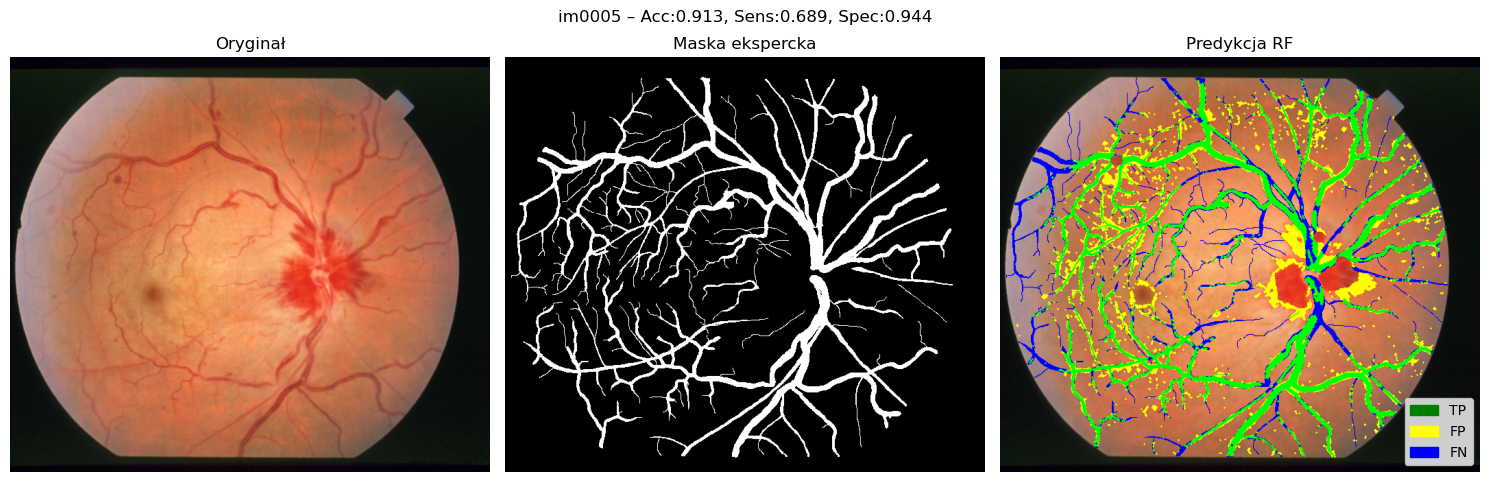

In [15]:
import os
import gzip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import moments_central, moments_hu
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score,
    roc_curve
)
from sklearn.model_selection import train_test_split


base_dir     = "."
images_dir   = os.path.join(base_dir, "star_images")
ah_masks_dir = os.path.join(base_dir, "labels_ah")
vk_masks_dir = os.path.join(base_dir, "lables_vk")

files    = sorted(f for f in os.listdir(images_dir) if f.endswith(".ppm.gz"))
train_f  = files[:4]     
test_f   = files[4:]     

def create_fov(gray):
    _, t = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    k    = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    m    = cv2.morphologyEx(t, cv2.MORPH_CLOSE, k)
    m    = cv2.morphologyEx(m, cv2.MORPH_OPEN,  k)
    return (m > 0).astype(np.uint8)

def get_metrics(gt, pred):
    y_t, y_p       = gt.flatten(), pred.flatten()
    tn, fp, fn, tp = confusion_matrix(y_t, y_p).ravel()
    acc   = accuracy_score(y_t, y_p)
    sens  = recall_score(y_t, y_p, zero_division=0)
    spec  = tn / (tn + fp) if (tn + fp) > 0 else 0
    return acc, sens, spec, (tn, fp, fn, tp)

def postprocess_mask(mask_bin):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opened = cv2.morphologyEx(mask_bin, cv2.MORPH_OPEN,  kernel)
    closed = cv2.morphologyEx(opened,   cv2.MORPH_CLOSE, kernel)
    return closed

def extract_features_from_patch(patch):
    p = patch.astype(np.float64)
    v = np.var(p)
    mean_intensity = np.mean(p)
    gx = cv2.Sobel(p, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(p, cv2.CV_64F, 0, 1, ksize=3)
    grad_mean = np.mean(np.sqrt(gx**2 + gy**2))
    if v == 0.0:
        hu = [0.0]*7
    else:
        mc = moments_central(p)
        hu = moments_hu(mc)
        hu = [0.0 if np.isnan(x) or np.isinf(x) else x for x in hu]
    return [v, mean_intensity, grad_mean] + hu

def extract_data(gray, mask, patch_size=5, stride=1):
    X, y, coords = [], [], []
    off = patch_size // 2
    h, w = gray.shape
    for i in range(off, h-off, stride):
        for j in range(off, w-off, stride):
            if mask[i, j] not in (0, 1):
                continue
            patch = gray[i-off:i+off+1, j-off:j+off+1]
            feats = extract_features_from_patch(patch)
            X.append(feats)
            y.append(mask[i, j])
            coords.append((i, j))
    return np.array(X), np.array(y), coords

#zbior trening
Xtr, ytr = [], []
for fn in train_f:
    name = fn.replace(".ppm.gz", "")
    img  = load_ppm_gz(os.path.join(images_dir, fn))
    m_ah = load_ppm_gz(os.path.join(ah_masks_dir, f"{name}.ah.ppm.gz")) > 0
    vk_p = os.path.join(vk_masks_dir, f"{name}.vk.ppm.gz")
    m_vk = (load_ppm_gz(vk_p) > 0) if os.path.exists(vk_p) else np.zeros_like(m_ah)
    mask = ((m_ah.astype(int) + m_vk.astype(int)) >= 1).astype(np.uint8)

    rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = apply_preprocessing(rgb)
    fov  = create_fov(gray)
    gray *= fov

    Xf, yf, _ = extract_data(gray, mask, patch_size=5, stride=1)
    Xtr.extend(Xf)
    ytr.extend(yf)

Xtr = np.nan_to_num(np.array(Xtr))
ytr = np.array(ytr)

# balansowanie klas
pos_idx = np.where(ytr == 1)[0]
neg_idx = np.where(ytr == 0)[0]
neg_sel = np.random.choice(neg_idx, size=len(pos_idx), replace=False)
sel     = np.concatenate([pos_idx, neg_sel])
Xbal, ybal = Xtr[sel], ytr[sel]

# train/val i tren RF
X_train, X_val, y_train, y_val = train_test_split(
    Xbal, ybal, test_size=0.3, random_state=42, stratify=ybal
)

clf = make_pipeline(
    StandardScaler(),  
    RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
)
clf.fit(X_train, y_train)

# automatyczne dobranie progu z walidacji
probs_val = clf.predict_proba(X_val)[:,1]
fpr, tpr, thr = roc_curve(y_val, probs_val)
best_idx = np.argmax(tpr - fpr)
best_thr = thr[best_idx]
print(f"Wybrany próg z ROC (Youden’s J): {best_thr:.3f}")

# na jednym obrazie i postprocessing
test_fn = test_f[0]
name    = test_fn.replace(".ppm.gz", "")

img  = load_ppm_gz(os.path.join(images_dir, test_fn))
m_ah = load_ppm_gz(os.path.join(ah_masks_dir, f"{name}.ah.ppm.gz")) > 0
vk_p = os.path.join(vk_masks_dir, f"{name}.vk.ppm.gz")
m_vk = (load_ppm_gz(vk_p) > 0) if os.path.exists(vk_p) else np.zeros_like(m_ah)
mask = ((m_ah.astype(int) + m_vk.astype(int)) >= 1).astype(np.uint8)

rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = apply_preprocessing(rgb)
fov  = create_fov(gray)
gray *= fov

Xte, yte, coords = extract_data(gray, mask, patch_size=5, stride=1)
Xte = np.nan_to_num(Xte)
probs_test = clf.predict_proba(Xte)[:,1]
ypred = (probs_test >= best_thr).astype(np.uint8)

pred_mask = np.zeros_like(mask)
for (i, j), v in zip(coords, ypred):
    pred_mask[i, j] = v
pred_mask = postprocess_mask(pred_mask)
# oblicz maski pomyłek i trafień
tn_mask = (mask == 0) & (pred_mask == 0) & (fov == 1)
fp_mask = (mask == 0) & (pred_mask == 1) & (fov == 1)
fn_mask = (mask == 1) & (pred_mask == 0) & (fov == 1)
tp_mask = (mask == 1) & (pred_mask == 1) & (fov == 1)

# zbuduj overlay – nałożenie kolorów na RGB
overlay = rgb.copy()
overlay[tp_mask] = [0, 255, 0]      # TP – zielony
overlay[fp_mask] = [255, 255, 0]    # FP – magenta
overlay[fn_mask] = [0, 0, 255] 

# metryki
acc, sens, spec, (tn, fp, fn, tp) = get_metrics(mask, pred_mask)
print(f"\n==== {name} ====")
print(f"Accuracy:    {acc:.4f}")
print(f"Sensitivity: {sens:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"Confusion matrix:\n[[TN:{tn}, FP:{fp}]\n [FN:{fn}, TP:{tp}]]")

# wizualizacja
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(rgb);               axs[0].set_title("Oryginał");        axs[0].axis('off')
axs[1].imshow(mask, cmap='gray'); axs[1].set_title("Maska ekspercka"); axs[1].axis('off')
axs[2].imshow(overlay);                axs[2].set_title("Predykcja RF");   axs[2].axis('off')
plt.suptitle(f"{name} – Acc:{acc:.3f}, Sens:{sens:.3f}, Spec:{spec:.3f}")
green = mpatches.Patch(color='green',   label='TP')
yellow = mpatches.Patch(color='yellow', label='FP')
blue = mpatches.Patch(color='blue',    label='FN')

axs[2].legend(handles=[green, yellow, blue], loc='lower right')
plt.tight_layout()
plt.show()


In [2]:
pip install tensorflow


  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (644.9 MB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


 przed treningiem CNN 
X_train: (493555, 5, 5, 1) y_train: (493555,)
X_val:   (123389, 5, 5, 1) y_val:   (123389,)
Liczba pikseli klasa 0 w train: 246777 klasa 1 w train: 246778
Liczba pikseli klasa 0 w val:   61695 klasa 1 w val:   61694


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 5, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 16)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,977 (27.25 KB)

 Trainable params: 6,977 (27.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3856/3856 - 19s - 5ms/step - accuracy: 0.7040 - loss: 0.5705 - val_accuracy: 0.7562 - val_loss: 0.5094 - learning_rate: 1.0000e-04
Epoch 2/20
3856/3856 - 17s - 5ms/step - accuracy: 0.7735 - loss: 0.4790 - val_accuracy: 0.7973 - val_loss: 0.4393 - learning_rate: 1.0000e-04
Epoch 3/20
3856/3856 - 18s - 5ms/step - accuracy: 0.8028 - loss: 0.4329 - val_accuracy: 0.8109 - val_loss: 0.4177 - learning_rate: 1.0000e-04
Epoch 4/20
3856/3856 - 18s - 5ms/step - accuracy: 0.8128 - loss: 0.4165 - val_accuracy: 0.8179 - val_loss: 0.4045 - learning_rate: 1.0000e-04
Epoch 5/20
3856/3856 - 18s - 5ms/step - accuracy: 0.8170 - loss: 0.4096 - val_accuracy: 0.8193 - val_loss: 0.4013 - learning_rate: 1.0000e-04
Epoch 6/20
3856/3856 - 18s - 5ms/step - accuracy: 0.8188 - loss: 0.4055 - val_accuracy: 0.8210 - val_loss: 0.3976 - learning_rate: 1.0000e-04
Epoch 7/20
3856/3856 - 18s - 5ms/step - accuracy: 0.8204 - loss: 0.4026 - val_accuracy: 0.8219 - val_loss: 0.3964 - learning_rate: 1.0000e-04
Epoch 

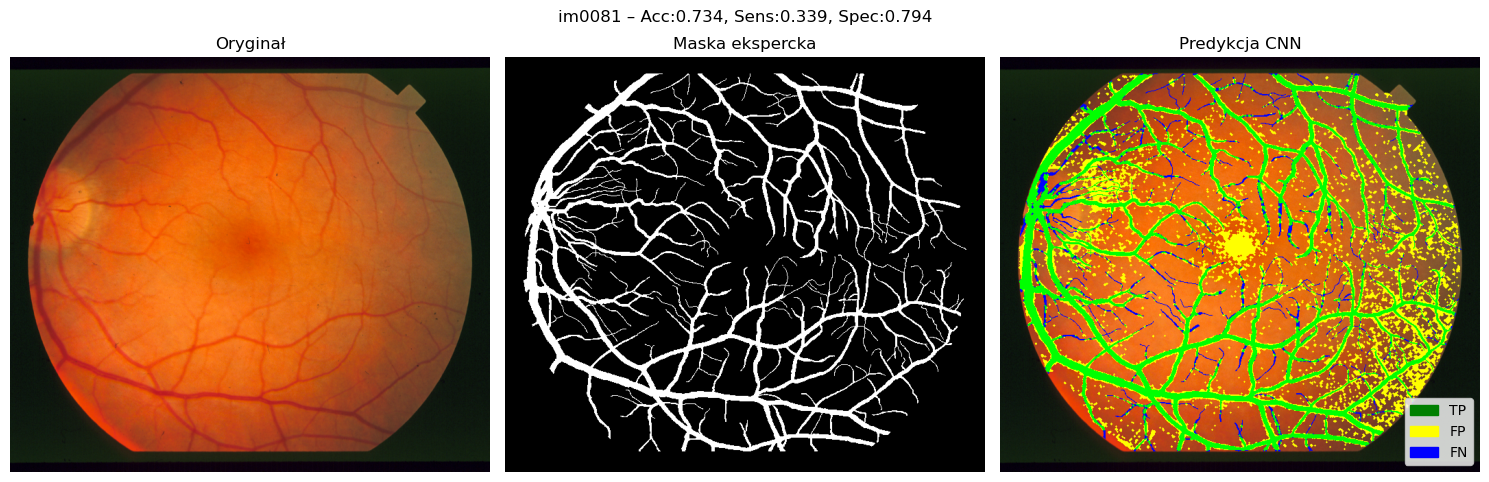

In [17]:
import os
import gzip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


def create_fov(gray):
    """
    FOV jako binary mask
    Otsu, zamknięcie, otwarcie
    """
    _, t = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    k    = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    m    = cv2.morphologyEx(t, cv2.MORPH_CLOSE, k)
    m    = cv2.morphologyEx(m, cv2.MORPH_OPEN,  k)
    return (m > 0).astype(np.uint8)



def overlay_vessels(rgb, vessel_mask, fov_mask):
    """
    Nakłada zielone piksele tam, gdzie (vessel_mask==1) AND (fov_mask==1)
    rgb tablica uint8 w kształcie (H,W,3)
    vessel_mask, fov_mask: 0/1, float lub uint8 w kształcie (H,W)
    Zwraca kolorowy obraz uint8 z nakładką [0,255,0]
    """
    out = rgb.copy()
    mask_overlay = (vessel_mask == 1) & (fov_mask == 1)
    out[mask_overlay] = [0, 255, 0]
    return out


def extract_patches(gray, mask, patch_size=5, stride=1):
    """
    Z funkcji extract_data→ tylko pobieramy surowy patch (patch_size×patch_size)
    oraz etykietę 0/1 w zależności od środka patcha
    Zwraca listę lista_patchy, lista_labeli, lista_koord
      - patch: shape=(patch_size, patch_size), dtype=uint8
      - label: 0 lub 1 (mask[i,j])
      - coords: (i,j) współrzędne środka patcha
    """
    offset = patch_size // 2
    h, w   = gray.shape
    patches, labels, coords = [], [], []
    for i in range(offset, h - offset, stride):
        for j in range(offset, w - offset, stride):
            # jeżeli środkowy piksel jest 0 lub 1:
            if mask[i, j] not in (0, 1):
                continue
            patch = gray[i-offset:i+offset+1, j-offset:j+offset+1]
            if patch.shape != (patch_size, patch_size):
                continue
            patches.append(patch)
            labels.append(mask[i, j])
            coords.append((i, j))
    return np.array(patches), np.array(labels), coords


def build_patch_cnn(patch_size=5):
    """
    patch_size, patch_size, 1
      - Conv2D, ReLU, MaxPool
      - Conv2D, ReLU, MaxPool
      - Flatten, Dense, ReLU, Dropout, Dense, Sigmoid
    pojedyncza wartość sigmoid (0..1), prawdop. przynależności do klasy 1
    """
    inp = Input(shape=(patch_size, patch_size, 1))
    x   = Conv2D(16, (3,3), activation='relu', padding='same')(inp)
    x   = MaxPooling2D((2,2))(x)            # po tej warstwie rozmiar (patch_size/2, patch_size/2, 16)
    x   = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x   = MaxPooling2D((2,2))(x)            # patch_size/4, patch_size/4, 32
    x   = Flatten()(x)
    x   = Dense(64, activation='relu')(x) #NIE UZYWAC DENSE (DO USUNIECIA)
    x   = Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid')(x) 

    model = Model(inputs=inp, outputs=out)
    return model

base_dir     = "."
images_dir   = os.path.join(base_dir, "star_images")
ah_masks_dir = os.path.join(base_dir, "labels_ah")
vk_masks_dir = os.path.join(base_dir, "lables_vk")

files   = sorted([f for f in os.listdir(images_dir) if f.endswith(".ppm.gz")])
train_f = files[:7]  
test_f  = files[7:]   

patch_size = 5
stride     = 1

X_patches, y_patches = [], []

for fn in train_f:
    name = fn.replace(".ppm.gz", "")
    img  = load_ppm_gz(os.path.join(images_dir, fn))
    rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = apply_preprocessing(rgb)
    fov  = create_fov(gray)
    gray *= fov 

    m_ah = load_ppm_gz(os.path.join(ah_masks_dir, f"{name}.ah.ppm.gz")) > 0
    vk_p = os.path.join(vk_masks_dir, f"{name}.vk.ppm.gz")
    m_vk = (load_ppm_gz(vk_p) > 0) if os.path.exists(vk_p) else np.zeros_like(m_ah)
    mask = ((m_ah.astype(int) + m_vk.astype(int)) >= 1).astype(np.uint8)

    patches, labels, _ = extract_patches(gray, mask, patch_size=patch_size, stride=stride)
    X_patches.append(patches)
    y_patches.append(labels)

X_patches = np.vstack(X_patches)  
y_patches = np.concatenate(y_patches)  


#  podzbiór równoliczny z klasy 0 i klasy 1 (undersampling klasy 0)
pos_idx = np.where(y_patches == 1)[0]
neg_idx = np.where(y_patches == 0)[0]
n_pos   = len(pos_idx)
n_neg   = len(neg_idx)
np.random.seed(42)
neg_sel = np.random.choice(neg_idx, size=n_pos, replace=False)
sel     = np.concatenate([pos_idx, neg_sel])
X_sel   = X_patches[sel]
y_sel   = y_patches[sel]

X_sel = X_sel.astype(np.float32) / 255.0
X_sel = np.expand_dims(X_sel, axis=-1)  # kanał: N, 5,5,1
y_sel = y_sel.astype(np.uint8)

X_train, X_val, y_train, y_val = train_test_split(
    X_sel, y_sel, test_size=0.2, random_state=42, stratify=y_sel
)

print(" przed treningiem CNN ")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("Liczba pikseli klasa 0 w train:", np.sum(y_train==0), 
      "klasa 1 w train:", np.sum(y_train==1))
print("Liczba pikseli klasa 0 w val:  ", np.sum(y_val==0), 
      "klasa 1 w val:  ", np.sum(y_val==1))


model = build_patch_cnn(patch_size=patch_size)
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()


callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_patch_cnn.keras", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)


probs_val = model.predict(X_val).flatten()  # kształt (n_val,)
fpr, tpr, thresholds = roc_curve(y_val, probs_val)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_thr = thresholds[best_idx]
print(f"Wybrany próg z ROC (Youden’s J): {best_thr:.4f}")



test_fn = test_f[0]
name    = test_fn.replace(".ppm.gz", "")

img  = load_ppm_gz(os.path.join(images_dir, test_fn))
rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = apply_preprocessing(rgb)
fov  = create_fov(gray)
gray *= fov

m_ah = load_ppm_gz(os.path.join(ah_masks_dir, f"{name}.ah.ppm.gz")) > 0
vk_p = os.path.join(vk_masks_dir, f"{name}.vk.ppm.gz")
m_vk = (load_ppm_gz(vk_p) > 0) if os.path.exists(vk_p) else np.zeros_like(m_ah)
mask_gt = ((m_ah.astype(int) + m_vk.astype(int)) >= 1).astype(np.uint8)

patches_test, labels_test, coords = extract_patches(gray, mask_gt, patch_size=patch_size, stride=stride)
patches_test = patches_test.astype(np.float32) / 255.0
patches_test = np.expand_dims(patches_test, axis=-1)  

probs_test = model.predict(patches_test).flatten()

y_pred_labels = (probs_test >= best_thr).astype(np.uint8)

pred_mask = np.zeros_like(mask_gt, dtype=np.uint8)
for (i, j), lab in zip(coords, y_pred_labels):
    pred_mask[i, j] = lab

pred_mask = postprocess_mask(pred_mask)

# oblicz maski pomyłek i trafień
tn_mask = (mask_gt == 0) & (pred_mask == 0) & (fov == 1)
fp_mask = (mask_gt  == 0) & (pred_mask == 1) & (fov == 1)
fn_mask = (mask_gt  == 1) & (pred_mask == 0) & (fov == 1)
tp_mask = (mask_gt  == 1) & (pred_mask == 1) & (fov == 1)

# zbuduj overlay – nałożenie kolorów na RGB
overlay = rgb.copy()
overlay[tp_mask] = [0, 255, 0]      # TP – zielony
overlay[fp_mask] = [255, 255, 0]    # FP – magenta
overlay[fn_mask] = [0, 0, 255] 

# metryki
acc, sens, spec, (tn, fp, fn, tp) = get_metrics(mask, pred_mask)
print(f"\n==== {name} ====")
print(f"Accuracy:    {acc:.4f}")
print(f"Sensitivity: {sens:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"Confusion matrix:\n[[TN:{tn}, FP:{fp}]\n [FN:{fn}, TP:{tp}]]")

# wizualizacja
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(rgb);               axs[0].set_title("Oryginał");        axs[0].axis('off')
axs[1].imshow(mask_gt, cmap='gray'); axs[1].set_title("Maska ekspercka"); axs[1].axis('off')
axs[2].imshow(overlay);                axs[2].set_title("Predykcja CNN");   axs[2].axis('off')
plt.suptitle(f"{name} – Acc:{acc:.3f}, Sens:{sens:.3f}, Spec:{spec:.3f}")
green = mpatches.Patch(color='green',   label='TP')
yellow = mpatches.Patch(color='yellow', label='FP')
blue = mpatches.Patch(color='blue',    label='FN')

axs[2].legend(handles=[green, yellow, blue], loc='lower right')
plt.tight_layout()
plt.show()

In [5]:
pip install tensorflow


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Train: (12, 256, 256, 1) (12, 256, 256, 1)
Val:   (4, 256, 256, 1) (4, 256, 256, 1)
Test:  (4, 256, 256, 1) (4, 256, 256, 1)
Epoch 1/20
2/2 - 12s - 6s/step - accuracy: 0.5870 - loss: 1.2575 - val_accuracy: 0.3472 - val_loss: 1.2848 - learning_rate: 0.0010
Epoch 2/20
2/2 - 10s - 5s/step - accuracy: 0.3437 - loss: 1.2402 - val_accuracy: 0.3370 - val_loss: 1.2686 - learning_rate: 0.0010
Epoch 3/20
2/2 - 10s - 5s/step - accuracy: 0.3518 - loss: 1.2313 - val_accuracy: 0.3717 - val_loss: 1.2631 - learning_rate: 0.0010
Epoch 4/20
2/2 - 10s - 5s/step - accuracy: 0.3814 - loss: 1.2192 - val_accuracy: 0.3827 - val_loss: 1.2313 - learning_rate: 0.0010
Epoch 5/20
2/2 - 10s - 5s/step - accuracy: 0.3895 - loss: 1.1858 - val_accuracy: 0.4412 - val_loss: 1.1764 - learning_rate: 0.0010
Epoch 6/20
2/2 - 10s - 5s/step - accuracy: 0.4344 - loss: 1.1092 - val_accuracy: 0.4015 - val_loss: 1.1017 - learning_rate: 0.0010
Epoch 7/20
2/2 - 10s - 5s/step - accuracy: 0.4060 - loss: 1.0533 - val_accuracy: 0.3946 -

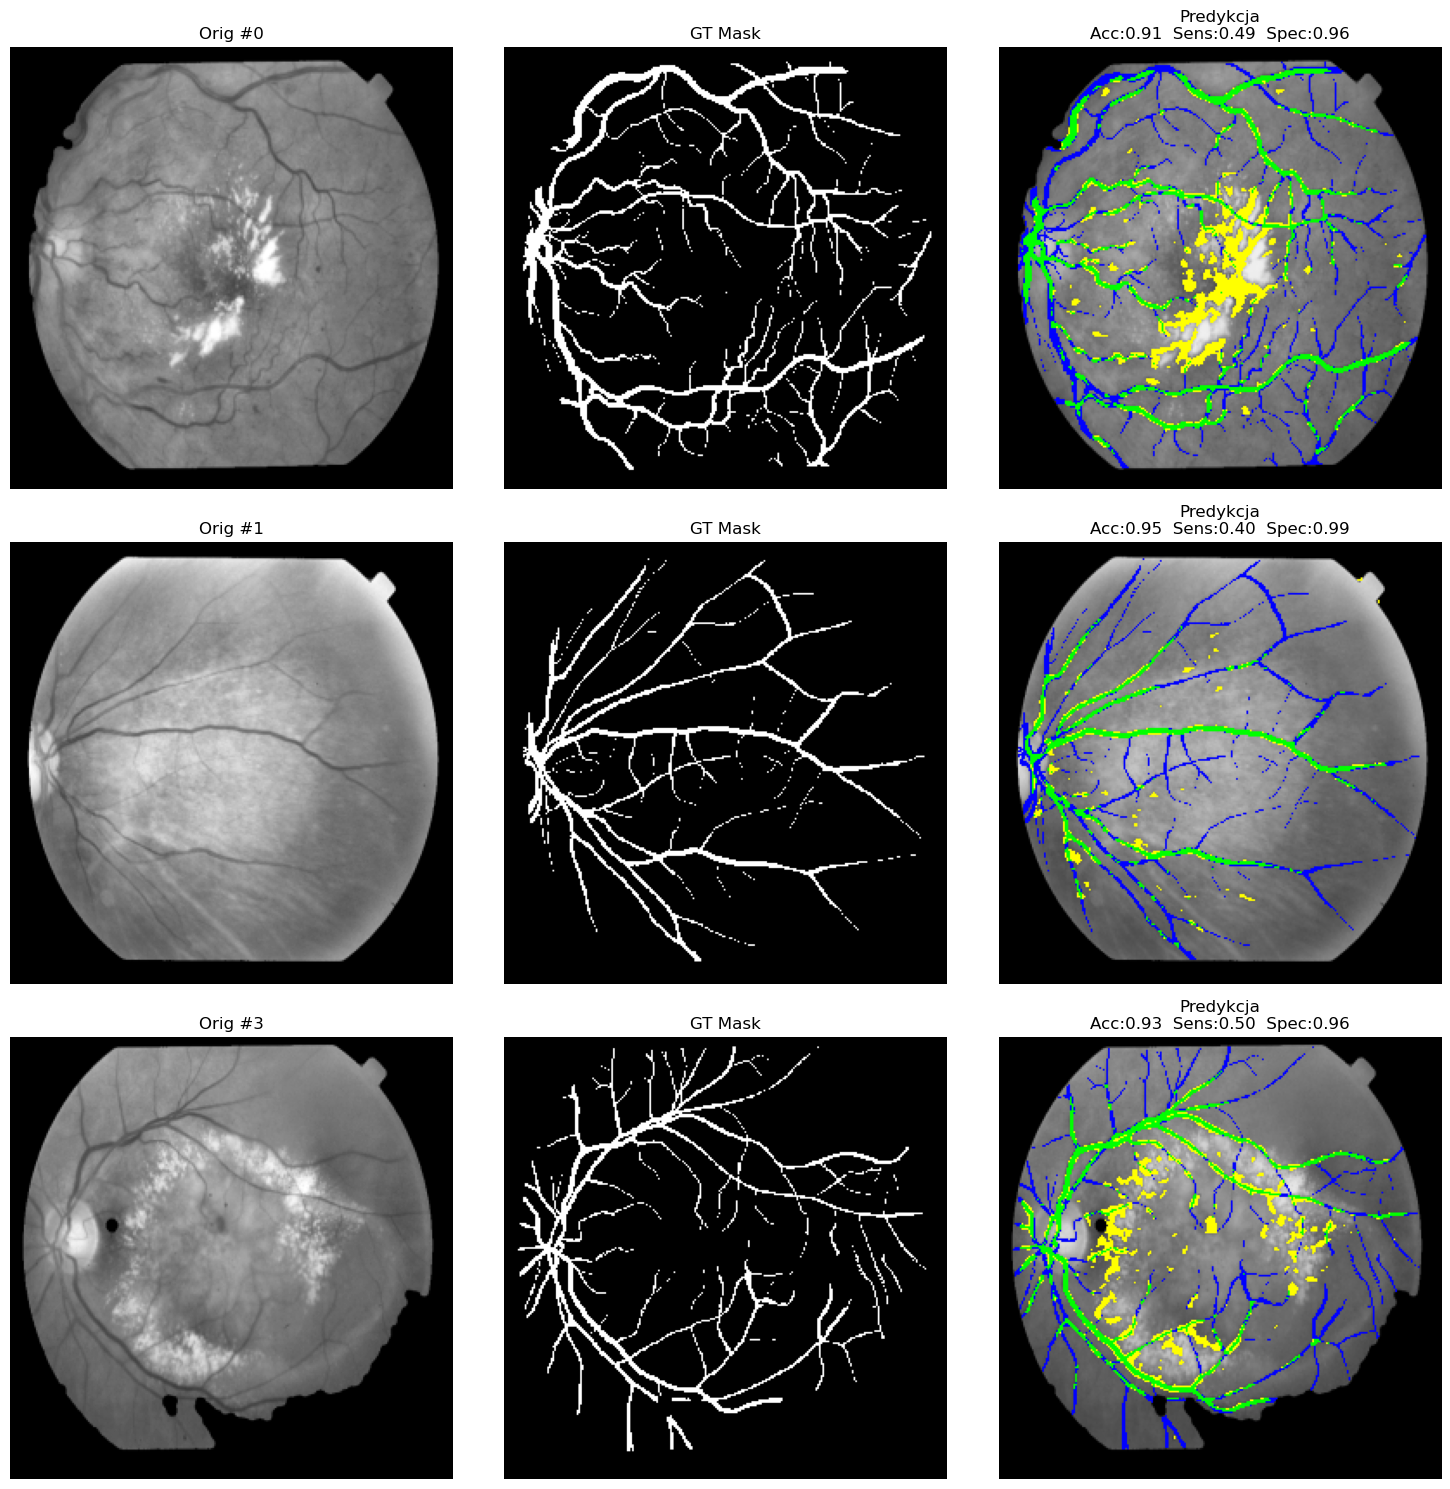

In [35]:
import os
import gzip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


pos_weight = 8

def weighted_bce(y_true, y_pred):
    # 1) standardowe BCE → (batch,H,W)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # 2) usuwasz ostatni singleton z y_true → (batch,H,W)
    y2 = tf.squeeze(y_true, axis=-1)
    weight = 1 + (pos_weight - 1) * y2
    return tf.reduce_mean(bce * weight)

base_dir     = "."
images_dir   = os.path.join(base_dir, "star_images")
ah_masks_dir = os.path.join(base_dir, "labels_ah")
vk_masks_dir = os.path.join(base_dir, "lables_vk")

IMG_SIZE = 256

# Zbierz wszystkie pliki *.ppm.gz
files = sorted(glob(os.path.join(images_dir, "*.ppm.gz")))

def postprocess_mask(mask_bin):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))  # było (3,3)
    opened = cv2.morphologyEx(mask_bin, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened,   cv2.MORPH_CLOSE, kernel)
    return closed

X, Y = [], []
for fn in files:
    name = os.path.basename(fn).replace(".ppm.gz", "")
    # obraz
    img = load_ppm_gz(os.path.join(images_dir, f"{name}.ppm.gz"))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = apply_preprocessing(rgb)
    fov  = create_field_of_view_mask(gray)
    gray = gray * fov

    # maska ekspercka
    m_ah = load_ppm_gz(os.path.join(ah_masks_dir, f"{name}.ah.ppm.gz")) > 0
    vk_p = os.path.join(vk_masks_dir, f"{name}.vk.ppm.gz")
    m_vk = (load_ppm_gz(vk_p)>0) if os.path.exists(vk_p) else np.zeros_like(m_ah)
    mask = ((m_ah.astype(int)+m_vk.astype(int))>=1).astype(np.uint8)
    mask = mask * fov  

    gray_r = cv2.resize(gray,  (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA)
    mask_r = cv2.resize(mask, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    gray_r = gray_r.astype(np.float32)/255.0
    mask_r = mask_r.astype(np.float32)

    # kanał
    X.append(np.expand_dims(gray_r, axis=-1))
    Y.append(np.expand_dims(mask_r, axis=-1))

X = np.stack(X, axis=0)  # (N, H, W, 1)
Y = np.stack(Y, axis=0)  # (N, H, W, 1)

X_tmp, X_test, Y_tmp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_tmp, Y_tmp, test_size=0.2, random_state=42)

print("Train:",  X_train.shape, Y_train.shape)
print("Val:  ",  X_val.shape,   Y_val.shape)
print("Test: ",  X_test.shape,  Y_test.shape)


def unet(input_shape=(IMG_SIZE,IMG_SIZE,1), dropout=0.3):
    inp = Input(input_shape)

    # down 1
    c1 = Conv2D(64, 3, activation="relu", padding="same")(inp)
    c1 = Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = MaxPooling2D()(c1)

    # down 2
    c2 = Conv2D(128,3,activation="relu",padding="same")(p1)
    c2 = Conv2D(128,3,activation="relu",padding="same")(c2)
    p2 = MaxPooling2D()(c2)

    # bottleneck
    c3 = Conv2D(256,3,activation="relu",padding="same")(p2)
    c3 = Conv2D(256,3,activation="relu",padding="same")(c3)

    # up 1
    u4 = Conv2DTranspose(128, 2, strides=2, padding="same")(c3)
    m4 = concatenate([u4,c2])
    c4 = Conv2D(128,3,activation="relu",padding="same")(m4)
    c4 = Conv2D(128,3,activation="relu",padding="same")(c4)

    # up 2
    u5 = Conv2DTranspose(64, 2, strides=2, padding="same")(c4)
    m5 = concatenate([u5,c1])
    c5 = Conv2D(64,3,activation="relu",padding="same")(m5)
    c5 = Conv2D(64,3,activation="relu",padding="same")(c5)

    # output
    out = Conv2D(1, 1, activation="sigmoid")(c5)
    return Model(inp, out)

model = unet()
model.compile(
    optimizer="adam",
    loss=weighted_bce,
    metrics=["accuracy"]
)


callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_unet.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=8,
    callbacks=callbacks,
    verbose=2
)


probs_val_flat = model.predict(X_val).flatten()            # (4*256*256,)
y_val_flat     = Y_val.flatten()                           # (4*256*256,)
fpr, tpr, th   = roc_curve(y_val_flat, probs_val_flat)
best_idx       = np.argmax(tpr - fpr)
best_thr       = th[best_idx]

# 2) spłaszcz once
probs_test_flat = model.predict(X_test).flatten()          # (4*256*256,)
y_test_flat     = Y_test.flatten()                         # (4*256*256,)

# 3) sprawdź spec/sens dla kilku delt
from sklearn.metrics import confusion_matrix

print("delta\tSpec\tSens")
for delta in [0.00, 0.05, 0.10, 0.15]:
    thr    = best_thr + delta
    y_pred = (probs_test_flat >= thr).astype(np.uint8)

    tn, fp, fn, tp = confusion_matrix(y_test_flat, y_pred).ravel()
    spec = tn / (tn + fp) if (tn+fp)>0 else 0
    sens = tp / (tp + fn) if (tp+fn)>0 else 0

    print(f"{delta:.2f}\t{spec:.3f}\t{sens:.3f}")

# 4) wybierz swój delta (np. delta=0.05) i policz ostateczne metryki:
delta = 0.05
thr   = best_thr + delta
y_pred_final = (probs_test_flat >= thr).astype(np.uint8)

tn, fp, fn, tp = confusion_matrix(y_test_flat, y_pred_final).ravel()
acc  = accuracy_score(y_test_flat,   y_pred_final)
sens = recall_score(y_test_flat,     y_pred_final)
spec = tn / (tn + fp)

print(f"\nFinal — Acc:{acc:.3f}, Sens:{sens:.3f}, Spec:{spec:.3f}")
print(f"Confusion matrix:\n[[TN:{tn}, FP:{fp}]\n [FN:{fn}, TP:{tp}]]")

# wskaż, które trzy przypadki pokazać
indices = [0, 1, 3]

fig, axes = plt.subplots(len(indices), 3, figsize=(15, 5*len(indices)))

for row, idx in enumerate(indices):
    # --- 1) przygotowanie obrazów i masek ---
    orig_gray = (X_test[idx,...] * 255).astype(np.uint8).squeeze()
    rgb       = cv2.cvtColor(orig_gray, cv2.COLOR_GRAY2BGR)
    mask_gt   = Y_test[idx,...].squeeze()                         # 2D 0/1
    pred_mask = y_pred_final.reshape(-1, IMG_SIZE, IMG_SIZE)[idx] # 2D 0/1
    fov       = create_field_of_view_mask(orig_gray)

    # --- 2) obliczanie metryk dla tego obrazu ---
    y_t        = mask_gt.flatten()
    y_p        = pred_mask.flatten()
    tn, fp, fn, tp = confusion_matrix(y_t, y_p).ravel()
    acc        = (tn + tp) / (tn + fp + fn + tp)
    sens       = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec       = tn / (tn + fp) if (tn + fp) > 0 else 0

    # --- 3) tworzenie overlay’u ---
    overlay = rgb.copy()
    tp_m = (mask_gt==1)&(pred_mask==1)&(fov==1)
    fp_m = (mask_gt==0)&(pred_mask==1)&(fov==1)
    fn_m = (mask_gt==1)&(pred_mask==0)&(fov==1)
    overlay[tp_m] = [0,255,0]
    overlay[fp_m] = [255,255,0]
    overlay[fn_m] = [0,0,255]

    # --- 4) rysowanie ---
    ax0, ax1, ax2 = axes[row]
    ax0.imshow(orig_gray, cmap="gray")
    ax0.set_title(f"Orig #{idx}")
    ax0.axis("off")

    ax1.imshow(mask_gt, cmap="gray")
    ax1.set_title("GT Mask")
    ax1.axis("off")

    ax2.imshow(overlay)
    ax2.set_title(
        f"Predykcja\nAcc:{acc:.2f}  Sens:{sens:.2f}  Spec:{spec:.2f}"
    )
    ax2.axis("off")

plt.tight_layout()
plt.show()